In [1]:
%load_ext autoreload
%autoreload 2
import IPython.display as ipd

In [2]:
import random
import os, re, logging
import sys
import numpy as np
import pdb
import torch

now_dir = os.getcwd()
sys.path.append(now_dir)
sys.path.append("%s/GPT_SoVITS" % (now_dir))

from TTS_infer_pack.TTS import TTS, TTS_Config
from TTS_infer_pack.text_segmentation_method import get_method
from tools.i18n.i18n import I18nAuto, scan_language_list



In [3]:

logging.getLogger("markdown_it").setLevel(logging.ERROR)
logging.getLogger("urllib3").setLevel(logging.ERROR)
logging.getLogger("httpcore").setLevel(logging.ERROR)
logging.getLogger("httpx").setLevel(logging.ERROR)
logging.getLogger("asyncio").setLevel(logging.ERROR)
logging.getLogger("charset_normalizer").setLevel(logging.ERROR)
logging.getLogger("torchaudio._extension").setLevel(logging.ERROR)

is_half = False #set to true for gpu inference
gpt_path = os.environ.get("gpt_path", None)
sovits_path = os.environ.get("sovits_path", None)
cnhubert_base_path = os.environ.get("cnhubert_base_path", None)
bert_path = os.environ.get("bert_path", None)
version="v2"

device = "cpu" # "cuda"

pretrained_sovits_name="GPT_SoVITS/pretrained_models/gsv-v2final-pretrained/s2G2333k.pth" #"GPT_SoVITS/pretrained_models/s2G488k.pth"]
pretrained_gpt_name="GPT_SoVITS/pretrained_models/gsv-v2final-pretrained/s1bert25hz-5kh-longer-epoch=12-step=369668.ckpt" #"GPT_SoVITS/pretrained_models/s1bert25hz-2kh-longer-epoch=68e-step=50232.ckpt"]


In [4]:

tts_config = TTS_Config("GPT_SoVITS/configs/tts_infer.yaml")
tts_config.device = device
tts_config.is_half = is_half
tts_config.version = version

tts_config.t2s_weights_path = pretrained_gpt_name
tts_config.vits_weights_path = pretrained_sovits_name
# print(tts_config)
  
tts_pipeline = TTS(tts_config)

Loading Text2Semantic weights from GPT_SoVITS/pretrained_models/gsv-v2final-pretrained/s1bert25hz-5kh-longer-epoch=12-step=369668.ckpt
Loading VITS weights from GPT_SoVITS/pretrained_models/gsv-v2final-pretrained/s2G2333k.pth
Loading BERT weights from GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large
Loading CNHuBERT weights from GPT_SoVITS/pretrained_models/chinese-hubert-base


In [5]:
batch_size = 8
fragment_interval = 0.3
speed_factor = 1.
top_k = 5
top_p = 1
temperature = 1
repetition_penalty = 1.35

cut_method = "cut4" #TODO: use my split method
split_bucket = False
parallel_infer = True

# ref_text = "Some call me nature, others call me mother nature."
# ref_audio_path = "basic_ref_en.wav"

ref_text = "I can still remember, or at least I believe I can remember, that this experience made a deep and lasting impression on me."
ref_audio_path = "reference_short.wav"

In [6]:
text = """I am sorry to knock you up so early, Doctor, said he, but I have had a very serious accident during the night. I came in by train this morning, and on inquiring at Paddington as to where I might find a doctor, a worthy fellow very kindly escorted me here. I gave the maid a card, but I see that she has left it upon the side table. I took it up and glanced at it. Mister Victor Hatherley, hydraulic engineer, sixteen A, Victoria Street (3rd floor). That was the name, style, and abode of my morning visitor. I regret that I have kept you waiting, said I, sitting down in my library chair. You are fresh from a night journey, I understand, which is in itself a monotonous occupation.
Since there is no time like the present, he thought it was time to present the present. He could lead if he would get the lead out. The buck does funny things when the does are present. The wind was too strong to wind the sail. The soldier decided to desert his dessert in the desert. He wound it around the wound, saying "I read it was $10 to read." You don’t have to memorize the minute details of the lectures to pass the history exam.
He lived in many places around the world. First, he lived in La Jolla, then moved to Nevada. Then he moved to Schenectady, then to Des Moines. After that he moved to Edinburgh and to Bologna. His favorite food was bologna sausage, gnocci with Worcestershire sauce with quinoa on the side."""


In [41]:

actual_seed = 1234

inputs={
    "text": text,
    "text_lang": "en",
    "ref_audio_path": ref_audio_path,
    "aux_ref_audio_paths": [], #[item.name for item in aux_ref_audio_paths] if aux_ref_audio_paths is not None else [],
    "prompt_text": ref_text,
    "prompt_lang": "en",
    "top_k": top_k,
    "top_p": top_p,
    "temperature": temperature,
    "text_split_method": cut_method,
    "batch_size":int(batch_size),
    "speed_factor":float(speed_factor),
    "split_bucket":split_bucket,
    "return_fragment":False,
    "fragment_interval":fragment_interval,
    "seed":actual_seed,
    "parallel_infer": parallel_infer,
    "repetition_penalty": repetition_penalty,
}

pipeline_output = tts_pipeline.run(inputs)
    
audio = []
for (sr, a) in pipeline_output:
    audio.append(a)

audio = np.concatenate(audio)


Set seed to 1234
并行推理模式已开启
分桶处理模式已关闭
Actual Input Reference Text: I can still remember, or at least I believe I can remember, that this experience made a deep and lasting impression on me.
############ 切分文本 ############
Actual Input Target Text:
I am sorry to knock you up so early,Doctor,said he,but I have had a very serious accident during the night.I came in by train this morning,and on inquiring at Paddington as to where I might find a doctor,a worthy fellow very kindly escorted me here.I gave the maid a card,but I see that she has left it upon the side table.I took it up and glanced at it.Mister Victor Hatherley,hydraulic engineer,sixteen A,Victoria Street (3rd floor).That was the name,style,and abode of my morning visitor.I regret that I have kept you waiting,said I,sitting down in my library chair.You are fresh from a night journey,I understand,which is in itself a monotonous occupation.

Since there is no time like the present,he thought it was time to present the present.He cou

100%|██████████| 20/20 [00:00<00:00, 592.13it/s]


############ 推理 ############
Processed text from the frontend (per sentence): ['I am sorry to knock you up so early,Doctor,said he,but I have had a very serious accident during the night. ', 'I came in by train this morning,and on inquiring at Paddington as to where I might find a doctor,a worthy fellow very kindly escorted me here. ', 'I gave the maid a card,but I see that she has left it upon the side table. ', 'I took it up and glanced at it. ', 'Mister Victor Hatherley,hydraulic engineer,sixteen A,Victoria Street  third floor. ', 'That was the name,style,and abode of my morning visitor. ', 'I regret that I have kept you waiting,said I,sitting down in my library chair. ', 'You are fresh from a night journey,I understand,which is in itself a monotonous occupation. ']


  1%|▏         | 22/1500 [00:01<01:14, 19.96it/s]

 15%|█▌        | 228/1500 [00:09<00:51, 24.79it/s]


T2S Decoding EOS [182 -> 411]
Processed text from the frontend (per sentence): ['Since there is no time like the present,he thought it was time to present the present. ', 'He could lead if he would get the lead out. ', 'The buck does funny things when the does are present. ', 'The wind was too strong to wind the sail. ', 'The soldier decided to desert his dessert in the desert. ', "He wound it around the wound,saying 'I read it was ten dollars to read. ", "' You don't have to memorize the minute details of the lectures to pass the history exam. ", 'He lived in many places around the world. ']


  8%|▊         | 122/1500 [00:05<01:06, 20.82it/s]


T2S Decoding EOS [182 -> 305]
Processed text from the frontend (per sentence): ['First,he lived in La Jolla,then moved to Nevada. ', 'Then he moved to Schenectady,then to Des Moines. ', 'After that he moved to Edinburgh and to Bologna. ', 'His favorite food was bologna sausage,gnocci with Worcestershire sauce with quinoa on the side. ']


 10%|█         | 155/1500 [00:05<00:44, 30.37it/s]


T2S Decoding EOS [182 -> 338]
0.000	0.040	20.194	9.253


In [ ]:
ipd.Audio(audio, rate=sr)

AttributeError: 'tuple' object has no attribute 'shape'

In [5]:
def spectrogram_torch(y, n_fft, sampling_rate, hop_size, win_size, center=False):
    hann_window = torch.hann_window(win_size).to(
            dtype=y.dtype, device=y.device
        )
    y = torch.nn.functional.pad(
        y.unsqueeze(1),
        (int((n_fft - hop_size) / 2), int((n_fft - hop_size) / 2)),
        mode="reflect",
    )
    y = y.squeeze(1)
    spec = torch.stft(
        y,
        n_fft,
        hop_length=hop_size,
        win_length=win_size,
        window=hann_window,
        center=center,
        pad_mode="reflect",
        normalized=False,
        onesided=True,
        return_complex=False,
    )
    spec = torch.sqrt(spec.pow(2).sum(-1) + 1e-6)
    return spec

In [6]:
import torchaudio
from text import cleaned_text_to_sequence
from feature_extractor import cnhubert

cnhubert_base_path = "GPT_SoVITS/pretrained_models/chinese-hubert-base"
cnhubert.cnhubert_base_path = cnhubert_base_path
ssl_model = cnhubert.get_model()


In [7]:
import onnxruntime
from transformers import AutoTokenizer
from TTS_infer_pack.TextPreprocessor import TextPreprocessor
from tools.my_utils import load_audio

providers = ["CPUExecutionProvider"]
t2s_encoder_sess = onnxruntime.InferenceSession("onnx/gsv_v2/gsv_v2_t2s_encoder.onnx", providers=providers)
t2s_fsdec_sess = onnxruntime.InferenceSession("onnx/gsv_v2/gsv_v2_t2s_fsdec.onnx", providers=providers)
t2s_sdec_sess = onnxruntime.InferenceSession("onnx/gsv_v2/gsv_v2_t2s_sdec.onnx", providers=providers)
vits_sess = onnxruntime.InferenceSession("onnx/gsv_v2/gsv_v2_vits.onnx", providers=providers)

bert_tokenizer = AutoTokenizer.from_pretrained("GPT_SoVITS/pretrained_models/chinese-roberta-wwm-ext-large")
text_preprocessor:TextPreprocessor = TextPreprocessor(None, bert_tokenizer, torch.device("cpu"))

In [8]:
tts_pipeline.t2s_model.config

{'train': {'seed': 1234,
  'epochs': 200,
  'batch_size': 5,
  'save_every_n_epoch': 1,
  'precision': '16-mixed',
  'gradient_clip': 1.0},
 'optimizer': {'lr': 0.01,
  'lr_init': 1e-05,
  'lr_end': 0.0001,
  'warmup_steps': 2000,
  'decay_steps': 40000},
 'data': {'max_eval_sample': 8,
  'max_sec': 57,
  'num_workers': 4,
  'pad_val': 1024},
 'model': {'vocab_size': 1025,
  'phoneme_vocab_size': 732,
  'embedding_dim': 512,
  'hidden_dim': 512,
  'head': 16,
  'linear_units': 2048,
  'n_layer': 24,
  'dropout': 0,
  'EOS': 1024,
  'random_bert': 0},
 'inference': {'top_k': 5}}

In [9]:
ref_text = "I can still remember, or at least I believe I can remember, that this experience made a deep and lasting impression on me."
ref_audio_path = "reference_short.wav"
sampling_rate = 32000

text = """I am sorry to knock you up so early, Doctor, said he, but I have had a very serious accident during the night. I came in by train this morning, and on inquiring at Paddington as to where I might find a doctor, a worthy fellow very kindly escorted me here. I gave the maid a card, but I see that she has left it upon the side table. I took it up and glanced at it. Mister Victor Hatherley, hydraulic engineer, sixteen A, Victoria Street (3rd floor). That was the name, style, and abode of my morning visitor. I regret that I have kept you waiting, said I, sitting down in my library chair. You are fresh from a night journey, I understand, which is in itself a monotonous occupation.
Since there is no time like the present, he thought it was time to present the present. He could lead if he would get the lead out. The buck does funny things when the does are present. The wind was too strong to wind the sail. The soldier decided to desert his dessert in the desert. He wound it around the wound, saying "I read it was $10 to read." You don’t have to memorize the minute details of the lectures to pass the history exam.
He lived in many places around the world. First, he lived in La Jolla, then moved to Nevada. Then he moved to Schenectady, then to Des Moines. After that he moved to Edinburgh and to Bologna. His favorite food was bologna sausage, gnocci with Worcestershire sauce with quinoa on the side."""
text_lang="en"
text_split_method="cut4"
version="v2"

text_preprocessed = text_preprocessor.preprocess(text, text_lang, text_split_method, version)
ref_text_preprocessed = text_preprocessor.preprocess(text, text_lang, text_split_method, version)

ref_seq = torch.LongTensor([ref_text_preprocessed[0]["phones"]])
text_seq = torch.LongTensor([text_preprocessed[0]["phones"]])

ref_bert = torch.zeros((ref_seq.shape[1], 1024)).float()
text_bert = torch.zeros((text_seq.shape[1], 1024)).float()
# ref_bert = torch.FloatTensor(ref_text_preprocessed[0]["bert_features"])
# text_bert = torch.FloatTensor(text_preprocessed[0]["bert_features"])
ref_audio = torch.tensor([load_audio(ref_audio_path, sr=sampling_rate)]).float()

# ref_audio = torch.tensor([load_audio("rec.wav", 48000)]).float()
ref_audio_16k = torchaudio.functional.resample(ref_audio, sampling_rate, 16000).float()
ref_audio_sr = torchaudio.functional.resample(ref_audio, sampling_rate, 32000).float()

ssl_content = ssl_model.model(ref_audio_16k)["last_hidden_state"].transpose(1, 2)


############ 切分文本 ############
Actual Input Target Text:
I am sorry to knock you up so early,Doctor,said he,but I have had a very serious accident during the night.I came in by train this morning,and on inquiring at Paddington as to where I might find a doctor,a worthy fellow very kindly escorted me here.I gave the maid a card,but I see that she has left it upon the side table.I took it up and glanced at it.Mister Victor Hatherley,hydraulic engineer,sixteen A,Victoria Street (3rd floor).That was the name,style,and abode of my morning visitor.I regret that I have kept you waiting,said I,sitting down in my library chair.You are fresh from a night journey,I understand,which is in itself a monotonous occupation.
Since there is no time like the present,he thought it was time to present the present.He could lead if he would get the lead out.The buck does funny things when the does are present.The wind was too strong to wind the sail.The soldier decided to desert his dessert in the desert.He 

100%|██████████| 20/20 [00:03<00:00,  5.36it/s]


############ 切分文本 ############
Actual Input Target Text:
I am sorry to knock you up so early,Doctor,said he,but I have had a very serious accident during the night.I came in by train this morning,and on inquiring at Paddington as to where I might find a doctor,a worthy fellow very kindly escorted me here.I gave the maid a card,but I see that she has left it upon the side table.I took it up and glanced at it.Mister Victor Hatherley,hydraulic engineer,sixteen A,Victoria Street (3rd floor).That was the name,style,and abode of my morning visitor.I regret that I have kept you waiting,said I,sitting down in my library chair.You are fresh from a night journey,I understand,which is in itself a monotonous occupation.
Since there is no time like the present,he thought it was time to present the present.He could lead if he would get the lead out.The buck does funny things when the does are present.The wind was too strong to wind the sail.The soldier decided to desert his dessert in the desert.He 

100%|██████████| 20/20 [00:00<00:00, 571.35it/s]


In [10]:
ref_seq.shape

torch.Size([1, 74])

In [15]:

(x, prompts) = t2s_encoder_sess.run(output_names=["x", "prompts"], input_feed={
    "ref_seq" : ref_seq.detach().cpu().numpy(),
    "text_seq" : text_seq.detach().cpu().numpy(),
    "ref_bert" : ref_bert.detach().cpu().numpy(),
    "text_bert" : text_bert.detach().cpu().numpy(),
    "ssl_content" : ssl_content.detach().cpu().numpy(),
})

prefix_len = prompts.shape[1]

#[1,N,512] [1,N]
y, k, v, y_emb, x_example =t2s_fsdec_sess.run(output_names=["y", "k", "v", "y_emb", "x_example"], input_feed={
    "x" : x, #.detach().cpu().numpy(),
    "prompts" : prompts, #.detach().cpu().numpy(),
})

In [16]:
max_sec = 57
hz = 50 
early_stop_num = hz * max_sec
EOS = 1024
stop = False

for idx in range(1, 1500):
    #[1, N] [N_layer, N, 1, 512] [N_layer, N, 1, 512] [1, N, 512] [1] [1, N, 512] [1, N]
    y, k, v, y_emb, logits, samples = t2s_sdec_sess.run(output_names=["y", "k", "v", "y_emb", "logits", "samples"], input_feed=
                                                        {"iy" : y, "ik" : k, "iv" : v, "iy_emb" : y_emb, "ix_example" : x_example})

    if early_stop_num != -1 and (y.shape[1] - prefix_len) > early_stop_num:
        stop = True
    if np.argmax(logits, axis=-1)[0] == EOS or samples[0, 0] == EOS:
        stop = True
    if stop:
        break
y[0, -1] = 0

pred_semantic = np.expand_dims(y[:, -idx:], axis=0)


In [21]:
audio = vits_sess.run(output_names=["audio"], input_feed={  "pred_semantic" : pred_semantic, "text_seq" : text_seq.detach().cpu().numpy(), "ref_audio" : ref_audio.detach().cpu().numpy()})

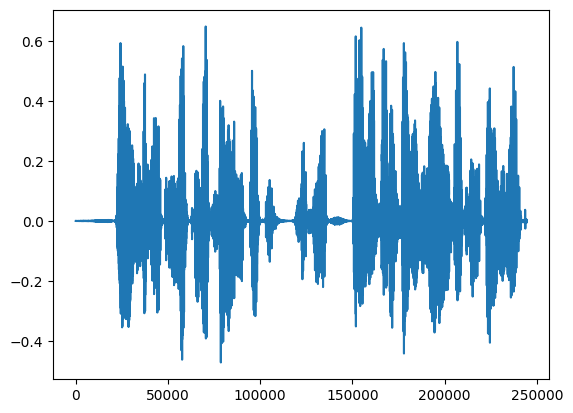

In [27]:
import pylab as pl 
pl.plot(audio[0])
ipd.Audio(audio[0], rate=32000)

In [ ]:
pred_semantic = self.t2s(ref_seq, text_seq, ref_bert, text_bert, ssl_content)
audio = self.vits(text_seq, pred_semantic, ref_audio)

In [ ]:
a, b = gpt_sovits(ref_seq, text_seq, ref_bert, text_bert, ref_audio_sr, ssl_content, debug=debug)
soundfile.write("out1.wav", a.cpu().detach().numpy(), vits.hps.data.sampling_rate)
soundfile.write("out2.wav", b[0], vits.hps.data.sampling_rate)

In [ ]:
pred_semantic = self.t2s(ref_seq, text_seq, ref_bert, text_bert, ssl_content)
torch.onnx.export(
    self.vits,
    (text_seq, pred_semantic, ref_audio),
    f"onnx/{project_name}/{project_name}_vits.onnx",
    input_names=["text_seq", "pred_semantic", "ref_audio"],
    output_names=["audio"],
    dynamic_axes={
        "text_seq": {1 : "text_length"},
        "pred_semantic": {2 : "pred_length"},
        "ref_audio": {1 : "audio_length"},
    },
    opset_version=17,
    verbose=False
)


In [ ]:
        torch.onnx.export(
            self.onnx_encoder,
            (ref_seq, text_seq, ref_bert, text_bert, ssl_content),
            f"onnx/{project_name}/{project_name}_t2s_encoder.onnx",
            input_names=["ref_seq", "text_seq", "ref_bert", "text_bert", "ssl_content"],
            output_names=["x", "prompts"],
            dynamic_axes={
                "ref_seq": {1 : "ref_length"},
                "text_seq": {1 : "text_length"},
                "ref_bert": {0 : "ref_length"},
                "text_bert": {0 : "text_length"},
                "ssl_content": {2 : "ssl_length"},
            },
            opset_version=16
        )
        x, prompts = self.onnx_encoder(ref_seq, text_seq, ref_bert, text_bert, ssl_content)

        torch.onnx.export(
            self.first_stage_decoder,
            (x, prompts),
            f"onnx/{project_name}/{project_name}_t2s_fsdec.onnx",
            input_names=["x", "prompts"],
            output_names=["y", "k", "v", "y_emb", "x_example"],
            dynamic_axes={
                "x": {1 : "x_length"},
                "prompts": {1 : "prompts_length"},
            },
            verbose=False,
            opset_version=16
        )
        y, k, v, y_emb, x_example = self.first_stage_decoder(x, prompts)

        torch.onnx.export(
            self.stage_decoder,
            (y, k, v, y_emb, x_example),
            f"onnx/{project_name}/{project_name}_t2s_sdec.onnx",
            input_names=["iy", "ik", "iv", "iy_emb", "ix_example"],
            output_names=["y", "k", "v", "y_emb", "logits", "samples"],
            dynamic_axes={
                "iy": {1 : "iy_length"},
                "ik": {1 : "ik_length"},
                "iv": {1 : "iv_length"},
                "iy_emb": {1 : "iy_emb_length"},
                "ix_example": {1 : "ix_example_length"},
            },
            verbose=False,
            opset_version=16
        )

